Note: must turn off radar in settings before recording

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Tue Jun 29 04:09:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

#imports + file upload
print("need to prune imports")
#h+=1

%tensorflow_version 2.x

import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image

assert len(tf.config.list_physical_devices('GPU')) > 0

from google.colab import files
from skimage.color import rgb2gray
from collections import Counter
from random import shuffle
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt 

import statistics

#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
need to prune imports


In [ ]:
#data processing

#next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

def data_processing(start_val,num_files):
  
  s_turn = []
  m_turn = []
  adj_turn = []
  no_turn = []
  reverse = []
  """
  #try with numpy array
  l_forward = []
  r_forward = []
  l_backward = []
  r_backward = []
  backward = []
  forward = []
  no_key = []

  w =  [1,0,0,0,0,0,0]
  s =  [0,1,0,0,0,0,0]
  wa = [0,0,1,0,0,0,0]
  wd = [0,0,0,1,0,0,0]
  sa = [0,0,0,0,1,0,0]
  sd = [0,0,0,0,0,1,0]
  nk = [0,0,0,0,0,0,1]
  """
  balanced_data = []
  starting_value = start_val
  continue_loop = True
  #start_time = time.time()
  #i=1
  while continue_loop:
    data_file_name = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(starting_value)
    if os.path.isfile(data_file_name) and starting_value < start_val + num_files:
      #print(len(forward))
      processed_data = np.load(data_file_name,allow_pickle=True)
      #time.sleep(1)
      print(starting_value)
      starting_value += 1
      #print(len(processed_data))
      #h+= 1
      #i = 0
      #for i in range(0,len(processed_data)):
      for entry in processed_data:
        y = entry[0][0:3]
        y_ls = round(y[2],2)
        y_ls_flipped = 1-y_ls
        x_raw= entry[1]
        x = cv2.resize(x_raw,(100, 100))
        #x = rgb2gray(entry[1])
        #flipping images
        #y_flipped = [y[0],y[1],1-y_ls]
        #x_flipped = cv2.flip(x, 1)
        #flipped_keys_pressed = ""
        #print(y_ls)
        
        if (y_ls > 0.875 or y_ls < 0.125):
          #very sharp turn, but it doesn't warrant its own array
          s_turn.append([x,y_ls])
          #s_turn.append([x_flipped,y_ls_flipped])
        elif (y_ls > 0.8 or y_ls < 0.2):
          #sharp turn
          #s_turn.append([x_flipped,y_ls_flipped])
          s_turn.append([x,y_ls])
        elif (y_ls > 0.68 or y_ls < 0.32):
          #medium turn
          m_turn.append([x,y_ls])
          #m_turn.append([x_flipped,y_ls_flipped])
          #i+=1

        elif (y_ls > 0.63 or y_ls < 0.37):
          #light turn, doesn't warrant its own array
          adj_turn.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
          #i+=1
        elif (y_ls > 0.56 or y_ls < 0.34):
          #light turn, doesn't warrant its own array
          adj_turn.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
        else:
          no_turn.append([x,y_ls])
          #no_turn.append([x_flipped,y_ls_flipped])
        
        """
        if (y_ls > 0.55 and y[1] > 0.1):
          r_forward.append([x,wd])
        elif (y_ls > 0.55 and y[0] > 0.1):
          r_backward.append([x,sd])
        elif (y_ls < 0.45 and y[1] > 0.1):
          l_forward.append([x,wa])
        elif (y_ls < 0.45 and y[0] > 0.1):
          l_backward.append([x,sa])
        elif y[1] > 0.1:
          forward.append([x,w])
        elif y[0] > 0.1:
          backward.append([x,s])
        else:
          no_key.append([x,nk])
        """
    else:
      if not (starting_value < start_val + num_files):
        continue_loop = False
        break
      else:
        print("file {} not found".format(starting_value))
        starting_value += 1

  #shuffle(no_turn)
  #without shuffling, array adjustment in next step would mean that the training set is full of mirror repeats 
  #we would prefer to have [img12_mirrored,img1] rather than [img1_mirrored, img1]
  #shuffling allows for this

  #balanced_data = s_turn[0:int(len(adj_turn)/3)] + m_turn + adj_turn[0:int(len(m_turn))] + no_turn[0:int(len(adj_turn)/3)]
  #we want agent to make small adjustments, so adj_turn isn't being adjusted
  #we don't want agent to just go straight, so less of no_turn is being added
  

  balanced_length=min(len(no_turn),len(adj_turn))

  #arr_lengths = [len(adj_turn),len(adj_turn),len(m_turn),len(s_turn)]
  #arr_lengths = [len(l_backward),balanced_length*1,len(r_backward),balanced_length*1.5,len(backward),balanced_length*1.5,balanced_length*1]
  #arr_names = ["no turn (trimmed)","adjustment turn","medium turn", "sharp turn"]
  #arr_names = ["l_backward","l_forward","r_backward", "r_forward","backward","forward","no key"]
  #plt.bar(arr_names,arr_lengths)
  #plt.show()
  
  
  #balanced_data = forward[:len(l_forward)] + backward + r_forward[:len(l_forward)] + l_forward + no_key + r_backward + l_backward #no_turn[0:balanced_length] + adj_turn[0:balanced_length] + m_turn[0:balanced_length] + s_turn[0:balanced_length]# + reverse

  balanced_data = no_turn[0:len(adj_turn)] + adj_turn + m_turn + s_turn
  
  no_turn = []
  s_turn = []
  m_turn = []
  adj_turn = []
  reverse = []
  #print(i)
  #[0:int(balanced_length*1.5)] + backward + forward[0:int(balanced_length*1.5)]+no_key[0:balanced_length*1]
  shuffle(balanced_data)
  X = []
  Y = []
  """
  for entry in balanced_data:
    entry[0] = rgb2gray(entry[0])
    print(np.array(entry[0]).shape)
    #entry[0] = np.expand_dims(rgb2gray(entry[0]), axis=0)

  """

  X , Y = zip(*balanced_data)

  print("done! have {} test cases".format(len(balanced_data)))
  #print("time to run time: {}".format(time.time()-start_time))
  balanced_data = []

  #X_train_3dim = tf.convert_to_tensor(X)
  #print(X_train_3dim.shape)
  #h+= 1
  #new_shape = list(X_train_3dim.shape) + [1]
  #X_train = tf.reshape(X_train_3dim,new_shape)

  #Y_train_3dim = tf.convert_to_tensor(Y)
  #print(Y_train_3dim.shape)
  #new_shape = list(Y_train_3dim.shape) + [1]
  #Y_train = tf.reshape(Y_train_3dim,new_shape)
  #Y_train_3dim = tf.transpose(Y_train_3dim,perm = [0,2,1])
  #print(Y_train.shape)
  #return X_train_3dim,Y_train_3dim
  return X,Y
 

In [ ]:
X_train, Y_train = data_processing(219,2)

219
220
done! have 452 test cases


In [ ]:
#saving chunk of training data as testing data (now irrelevant)

#PERCENT_TEST = 20

#test_index_start = int(PERCENT_TEST*len(balanced_data)/100)
#train_data = balanced_data[:-test_index_start]
#test_data = balanced_data[-test_index_start:]

In [ ]:


def build_driving_model():
  resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

  for layer in resnet.layers[:-4]:
      layer.trainable = False
  
  """
  for layer in resnet.layers:
      print(layer, layer.trainable)
  """
  model = Sequential()
  model.add(resnet)
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(250, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(100, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(20, activation='tanh'))
  #model.add(Dropout(0.5))
  #model.add(Dense(59, activation='tanh'))
  model.add(Dense(1))
  return model




#set up alexnet


def build_alexnet_model():
  #image_shape = (80,60,1)
  np.random.seed(1000)
  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
  model = tf.keras.Sequential([
    #tf.keras.layers.InputLayer(input_shape=image_shape),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5),strides=(2,2),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation=tf.nn.relu), 
    #tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)])
  
  return model

def build_alexnet_batchnorm_model():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),#, input_shape=(120, 160, 1)),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
  ])

  return model

def nvidia_modified():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2),activation='elu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))


  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(3))
  
  #Compile model
  #model.compile(tf.keras.optimizers.Adam(lr=0.001), loss = 'mse', metrics = ['accuracy'])
  return model



def build_cnn_model():
      cnn_model = tf.keras.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 2 to reduce the height and width of
        # the output.
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=2),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=3),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Because control vector is made up of 3 values, 
        # this dense layer is made up of only 3 units
        tf.keras.layers.Dense(3)])
      
      return cnn_model

import keras.backend as K
accepted_diff = 0.03
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    #tf.print(y_true)
    #tf.print(y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))

In [ ]:
print(5e-3)


0.005


----- --------STARTING EPOCH 1-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 8s 48ms/step - loss: 0.5379 - linear_regression_equality: 0.1007 - val_loss: 0.0429 - val_linear_regression_equality: 0.1141
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0480 - linear_regression_equality: 0.1171 - val_loss: 0.0430 - val_linear_regression_equality: 0.1208
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0490 - linear_regression_equality: 0.1250 - val_loss: 0.0457 - val_linear_regression_equality: 0.1387
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 39ms/step - loss: 0.0625 - linear_regression_equality: 0.1042 - val_loss: 0.0650 - val_linear_regression_equality: 0.0955
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

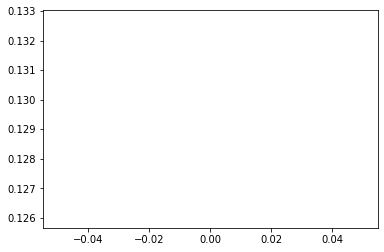

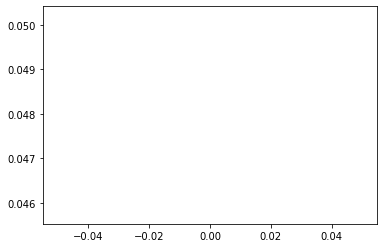

----- --------STARTING EPOCH 2-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 3s 38ms/step - loss: 0.0318 - linear_regression_equality: 0.1500 - val_loss: 0.0335 - val_linear_regression_equality: 0.1709
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0351 - linear_regression_equality: 0.1546 - val_loss: 0.0359 - val_linear_regression_equality: 0.1554
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0402 - linear_regression_equality: 0.1361 - val_loss: 0.0379 - val_linear_regression_equality: 0.1584
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 38ms/step - loss: 0.0494 - linear_regression_equality: 0.1237 - val_loss: 0.0485 - val_linear_regression_equality: 0.1369
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

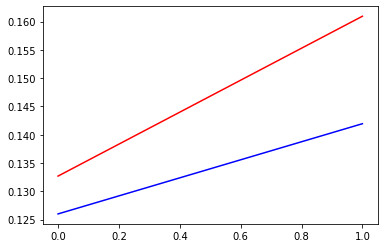

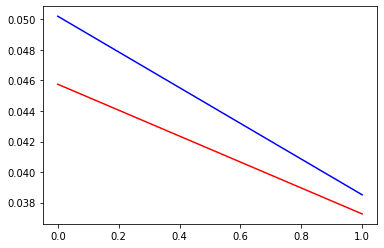

----- --------STARTING EPOCH 3-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 38ms/step - loss: 0.0284 - linear_regression_equality: 0.1666 - val_loss: 0.0236 - val_linear_regression_equality: 0.1809
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0320 - linear_regression_equality: 0.1633 - val_loss: 0.0294 - val_linear_regression_equality: 0.1687
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0358 - linear_regression_equality: 0.1470 - val_loss: 0.0368 - val_linear_regression_equality: 0.1531
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 38ms/step - loss: 0.0416 - linear_regression_equality: 0.1363 - val_loss: 0.0386 - val_linear_regression_equality: 0.1401
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

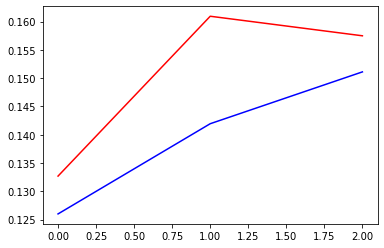

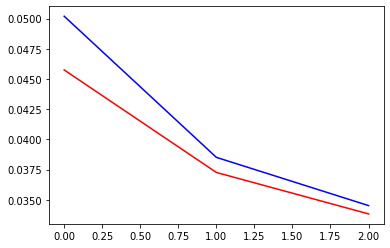

----- --------STARTING EPOCH 4-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0258 - linear_regression_equality: 0.1803 - val_loss: 0.0245 - val_linear_regression_equality: 0.1894
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0292 - linear_regression_equality: 0.1793 - val_loss: 0.0252 - val_linear_regression_equality: 0.1603
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0325 - linear_regression_equality: 0.1436 - val_loss: 0.0366 - val_linear_regression_equality: 0.1135
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 40ms/step - loss: 0.0369 - linear_regression_equality: 0.1420 - val_loss: 0.0315 - val_linear_regression_equality: 0.1755
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

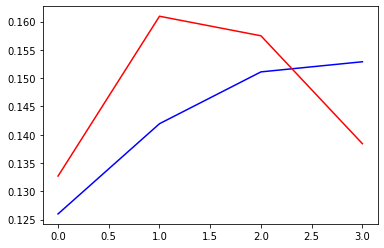

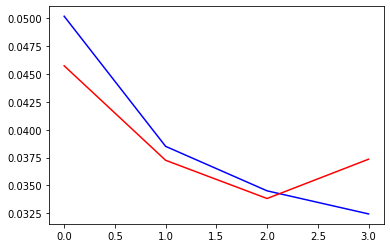

----- --------STARTING EPOCH 5-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0236 - linear_regression_equality: 0.1888 - val_loss: 0.0207 - val_linear_regression_equality: 0.2079
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0273 - linear_regression_equality: 0.1787 - val_loss: 0.0271 - val_linear_regression_equality: 0.1569
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0311 - linear_regression_equality: 0.1565 - val_loss: 0.0323 - val_linear_regression_equality: 0.1233
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0328 - linear_regression_equality: 0.1548 - val_loss: 0.0281 - val_linear_regression_equality: 0.1718
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

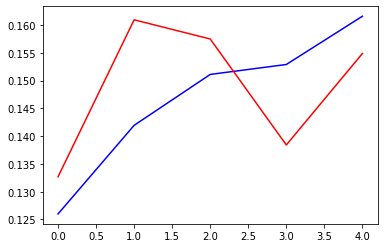

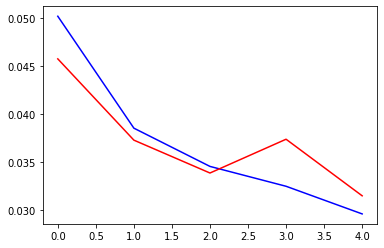

----- --------STARTING EPOCH 6-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0219 - linear_regression_equality: 0.1840 - val_loss: 0.0194 - val_linear_regression_equality: 0.2410
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0250 - linear_regression_equality: 0.1812 - val_loss: 0.0217 - val_linear_regression_equality: 0.2060
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0280 - linear_regression_equality: 0.1685 - val_loss: 0.0270 - val_linear_regression_equality: 0.1663
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 38ms/step - loss: 0.0301 - linear_regression_equality: 0.1595 - val_loss: 0.0252 - val_linear_regression_equality: 0.1784
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

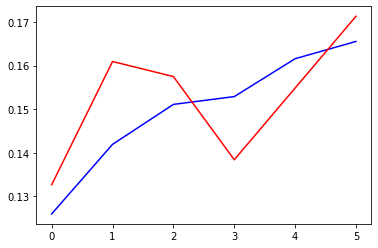

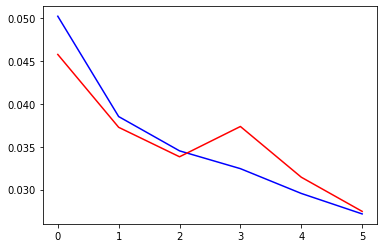

----- --------STARTING EPOCH 7-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0203 - linear_regression_equality: 0.2000 - val_loss: 0.0180 - val_linear_regression_equality: 0.1927
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0232 - linear_regression_equality: 0.1843 - val_loss: 0.0190 - val_linear_regression_equality: 0.2053
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0274 - linear_regression_equality: 0.1635 - val_loss: 0.0308 - val_linear_regression_equality: 0.1459
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0256 - linear_regression_equality: 0.1794 - val_loss: 0.0231 - val_linear_regression_equality: 0.1995
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

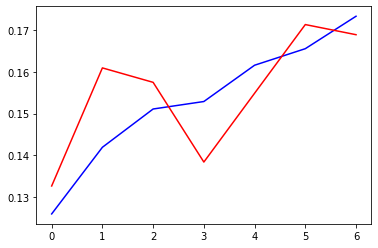

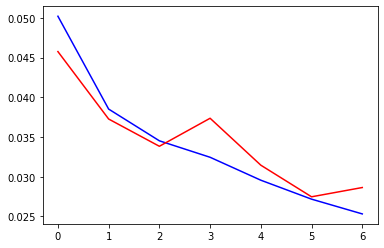

----- --------STARTING EPOCH 8-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0188 - linear_regression_equality: 0.2082 - val_loss: 0.0163 - val_linear_regression_equality: 0.2339
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0215 - linear_regression_equality: 0.1903 - val_loss: 0.0227 - val_linear_regression_equality: 0.1609
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 38ms/step - loss: 0.0250 - linear_regression_equality: 0.1763 - val_loss: 0.0257 - val_linear_regression_equality: 0.1825
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0238 - linear_regression_equality: 0.1774 - val_loss: 0.0249 - val_linear_regression_equality: 0.1485
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

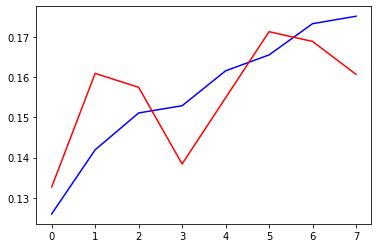

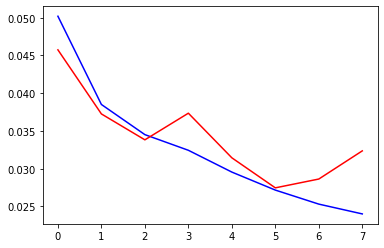

----- --------STARTING EPOCH 9-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0171 - linear_regression_equality: 0.2191 - val_loss: 0.0158 - val_linear_regression_equality: 0.2268
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0208 - linear_regression_equality: 0.1861 - val_loss: 0.0172 - val_linear_regression_equality: 0.1971
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0234 - linear_regression_equality: 0.1841 - val_loss: 0.0180 - val_linear_regression_equality: 0.2041
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 40ms/step - loss: 0.0214 - linear_regression_equality: 0.1905 - val_loss: 0.0193 - val_linear_regression_equality: 0.2058
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test ca

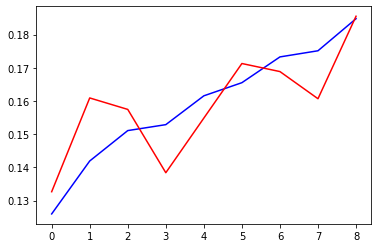

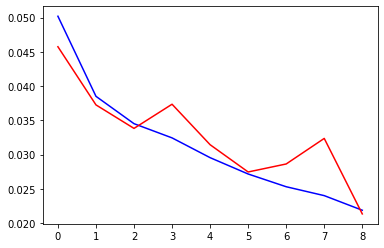

----- --------STARTING EPOCH 10-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 43ms/step - loss: 0.0164 - linear_regression_equality: 0.2124 - val_loss: 0.0165 - val_linear_regression_equality: 0.1965
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 38ms/step - loss: 0.0184 - linear_regression_equality: 0.2080 - val_loss: 0.0211 - val_linear_regression_equality: 0.1967
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0222 - linear_regression_equality: 0.1867 - val_loss: 0.0201 - val_linear_regression_equality: 0.2245
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0193 - linear_regression_equality: 0.1886 - val_loss: 0.0173 - val_linear_regression_equality: 0.2103
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

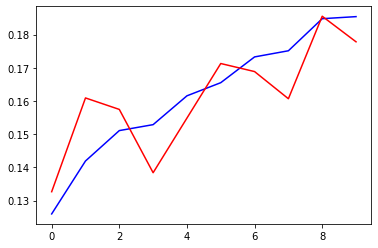

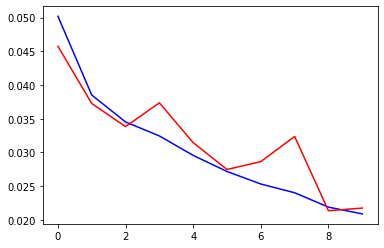

----- --------STARTING EPOCH 11-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 43ms/step - loss: 0.0159 - linear_regression_equality: 0.2212 - val_loss: 0.0154 - val_linear_regression_equality: 0.2055
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0173 - linear_regression_equality: 0.2085 - val_loss: 0.0172 - val_linear_regression_equality: 0.1938
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0201 - linear_regression_equality: 0.1905 - val_loss: 0.0181 - val_linear_regression_equality: 0.2072
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0182 - linear_regression_equality: 0.2062 - val_loss: 0.0154 - val_linear_regression_equality: 0.2195
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

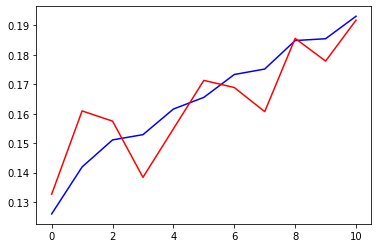

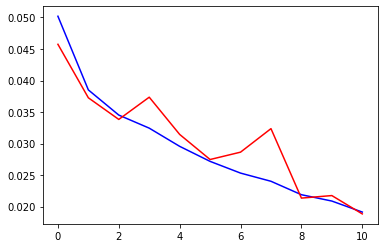

----- --------STARTING EPOCH 12-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 40ms/step - loss: 0.0141 - linear_regression_equality: 0.2244 - val_loss: 0.0139 - val_linear_regression_equality: 0.2405
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 42ms/step - loss: 0.0166 - linear_regression_equality: 0.2115 - val_loss: 0.0149 - val_linear_regression_equality: 0.2214
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0187 - linear_regression_equality: 0.1890 - val_loss: 0.0177 - val_linear_regression_equality: 0.2224
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0183 - linear_regression_equality: 0.1934 - val_loss: 0.0257 - val_linear_regression_equality: 0.1303
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

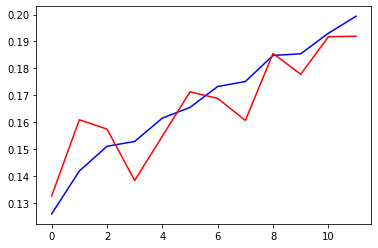

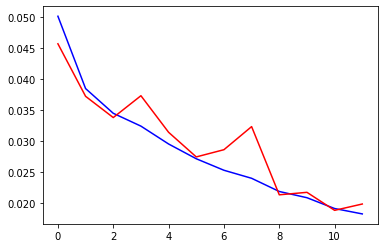

----- --------STARTING EPOCH 13-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0134 - linear_regression_equality: 0.2455 - val_loss: 0.0111 - val_linear_regression_equality: 0.2794
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0147 - linear_regression_equality: 0.2234 - val_loss: 0.0125 - val_linear_regression_equality: 0.2527
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 5s 42ms/step - loss: 0.0177 - linear_regression_equality: 0.2002 - val_loss: 0.0263 - val_linear_regression_equality: 0.1344
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 42ms/step - loss: 0.0146 - linear_regression_equality: 0.2255 - val_loss: 0.0152 - val_linear_regression_equality: 0.2219
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

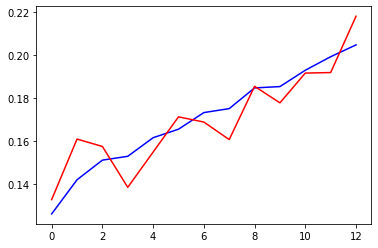

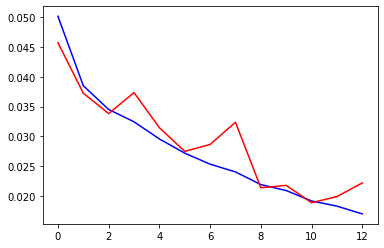

----- --------STARTING EPOCH 14-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 40ms/step - loss: 0.0122 - linear_regression_equality: 0.2400 - val_loss: 0.0150 - val_linear_regression_equality: 0.1927
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0145 - linear_regression_equality: 0.2234 - val_loss: 0.0153 - val_linear_regression_equality: 0.2051
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0162 - linear_regression_equality: 0.2066 - val_loss: 0.0119 - val_linear_regression_equality: 0.2329
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 41ms/step - loss: 0.0159 - linear_regression_equality: 0.2229 - val_loss: 0.0136 - val_linear_regression_equality: 0.2444
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

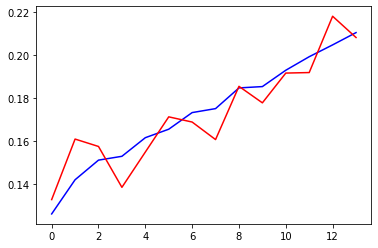

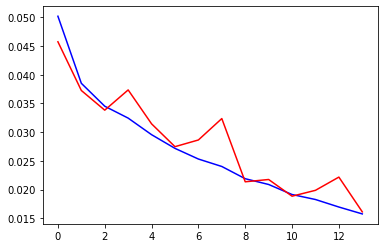

----- --------STARTING EPOCH 15-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0115 - linear_regression_equality: 0.2453 - val_loss: 0.0129 - val_linear_regression_equality: 0.2211
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 42ms/step - loss: 0.0131 - linear_regression_equality: 0.2362 - val_loss: 0.0155 - val_linear_regression_equality: 0.1880
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0152 - linear_regression_equality: 0.2084 - val_loss: 0.0144 - val_linear_regression_equality: 0.2380
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0143 - linear_regression_equality: 0.2291 - val_loss: 0.0151 - val_linear_regression_equality: 0.2111
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

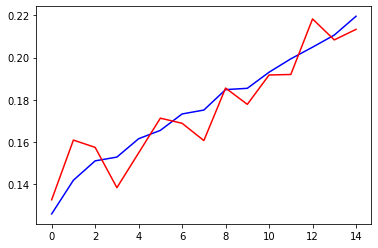

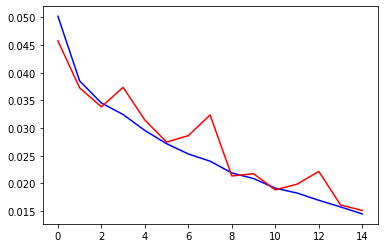

----- --------STARTING EPOCH 16-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0107 - linear_regression_equality: 0.2610 - val_loss: 0.0108 - val_linear_regression_equality: 0.2599
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0129 - linear_regression_equality: 0.2290 - val_loss: 0.0118 - val_linear_regression_equality: 0.2646
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 5s 41ms/step - loss: 0.0146 - linear_regression_equality: 0.2214 - val_loss: 0.0111 - val_linear_regression_equality: 0.2404
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 4s 39ms/step - loss: 0.0125 - linear_regression_equality: 0.2342 - val_loss: 0.0112 - val_linear_regression_equality: 0.2659
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

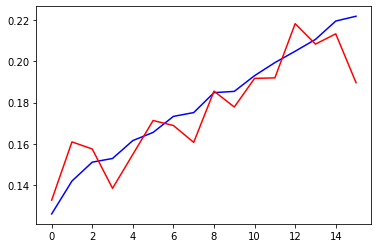

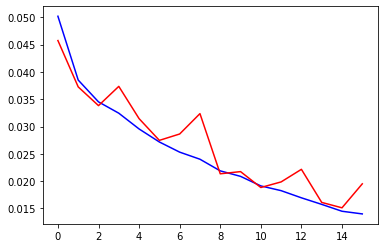

----- --------STARTING EPOCH 17-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 39ms/step - loss: 0.0104 - linear_regression_equality: 0.2594 - val_loss: 0.0102 - val_linear_regression_equality: 0.2543
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 39ms/step - loss: 0.0112 - linear_regression_equality: 0.2447 - val_loss: 0.0158 - val_linear_regression_equality: 0.2082
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 40ms/step - loss: 0.0141 - linear_regression_equality: 0.2156 - val_loss: 0.0138 - val_linear_regression_equality: 0.2130
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 39ms/step - loss: 0.0113 - linear_regression_equality: 0.2528 - val_loss: 0.0175 - val_linear_regression_equality: 0.1554
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

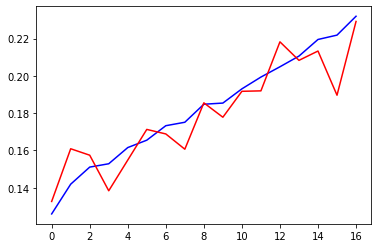

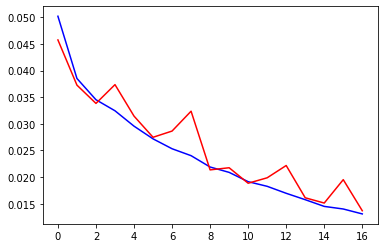

----- --------STARTING EPOCH 18-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 43ms/step - loss: 0.0102 - linear_regression_equality: 0.2499 - val_loss: 0.0085 - val_linear_regression_equality: 0.3139
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 5s 43ms/step - loss: 0.0115 - linear_regression_equality: 0.2377 - val_loss: 0.0094 - val_linear_regression_equality: 0.2698
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 40ms/step - loss: 0.0132 - linear_regression_equality: 0.2203 - val_loss: 0.0121 - val_linear_regression_equality: 0.1974
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 42ms/step - loss: 0.0108 - linear_regression_equality: 0.2562 - val_loss: 0.0098 - val_linear_regression_equality: 0.2866
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

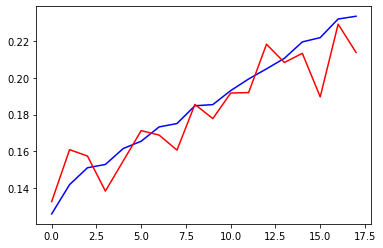

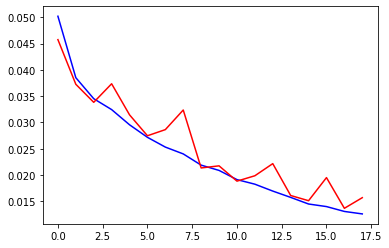

----- --------STARTING EPOCH 19-------------
0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
92/92 [==============================] - 4s 40ms/step - loss: 0.0092 - linear_regression_equality: 0.2693 - val_loss: 0.0083 - val_linear_regression_equality: 0.2633
10
11
12
13
14
15
16
17
18
19
done! have 7488 test cases
106/106 [==============================] - 4s 40ms/step - loss: 0.0109 - linear_regression_equality: 0.2548 - val_loss: 0.0092 - val_linear_regression_equality: 0.2655
20
21
22
23
24
25
26
27
28
29
done! have 7879 test cases
111/111 [==============================] - 4s 39ms/step - loss: 0.0116 - linear_regression_equality: 0.2403 - val_loss: 0.0102 - val_linear_regression_equality: 0.2784
30
31
32
33
34
35
36
37
38
39
done! have 8148 test cases
115/115 [==============================] - 5s 39ms/step - loss: 0.0099 - linear_regression_equality: 0.2619 - val_loss: 0.0118 - val_linear_regression_equality: 0.2343
40
file 41 not found
42
43
44
45
46
47
48
49
done! have 7563 test c

In [ ]:

#x = np.random.rand(2,160,120,1)
#X = tf.convert_to_tensor(x)

# Initialize the model by passing some data through
#predictions = cnn_model.predict(X_train_0)
#print(predictions)
#print(predictions.shape)
# Print the summary of the layers in the model.
#print(cnn_model.summary())

#load cnn model, load arrays
time_vals = []
train_accuracy = []
test_accuracy = []

epoch_to_load = int(input("which epoch to load?"))
if epoch_to_load > 0:
  cnn_model = keras.models.load_model('/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5'.format(epoch_to_load))
  graph_data = np.load('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',allow_pickle=True)
  time_vals = graph_data[0][0:epoch_to_load].tolist()
  train_accuracy = graph_data[1][0:epoch_to_load].tolist()
  test_accuracy = graph_data[2][0:epoch_to_load].tolist()
  plt.plot(time_vals, test_accuracy, label = "test accuracy")
  plt.plot(time_vals, train_accuracy, label = "train accuracy")
  plt.show()

else:
  cnn_model = build_driving_model()
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
  optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
  #optimizer = keras.optimizers.Adam(learning_rate=5e-3)
  cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])#metrics=['accuracy'])


BATCH_SIZE = 64
EPOCHS = 45

start_val = 0
num_files_to_retrieve = 10
num_files_to_test = 233

test_acc   = []
test_loss  = []
train_acc  = []
train_loss = []

for epoch in range(epoch_to_load+1,EPOCHS+1):
  epoch_test_acc   = []
  epoch_test_loss  = []
  epoch_train_acc  = []
  epoch_train_loss = []

  print('----- --------STARTING EPOCH {}-------------'.format(epoch))

  while start_val < num_files_to_test:
    X, Y= data_processing(start_val,num_files_to_retrieve)
    start_val += num_files_to_retrieve
    #num_files = X_train.shape[0]
    #files_in_epoch += num_files
    X_array = np.array(X).reshape(-1,100,100,3)
    Y_array = np.array(Y).reshape(-1,1)
    history = cnn_model.fit(X_array, Y_array, batch_size=BATCH_SIZE, epochs=1,validation_split=0.1)#,callbacks=[cp_callback])
    
    #print(history.history)
    epoch_train_acc.append(history.history['linear_regression_equality'][0])
    epoch_train_loss.append(history.history['loss'][0])
    epoch_test_loss.append(history.history['val_loss'][0])
    epoch_test_acc.append(history.history['val_linear_regression_equality'][0])
  
  #print(len(epoch_train_loss))
  print("avg train accuracy: {}".format(statistics.mean(epoch_train_acc)))
  print("avg test accuracy: {}".format(statistics.mean(epoch_test_acc)))
  train_acc.append(statistics.mean(epoch_train_acc))
  test_acc.append(statistics.mean(epoch_test_acc))
  train_loss.append(statistics.mean(epoch_train_loss))
  test_loss.append(statistics.mean(epoch_test_loss))
  
  time.sleep(1)
  start_val = 0
  if epoch % 15 == 0:# and epoch != 0:
        print("SAVED")
        file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch)
        cnn_model.save_weights(file_name)
        graph_data = [train_acc,test_acc,train_loss,test_loss]
        np.save('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',graph_data)

  f1 = plt.figure()
  f2 = plt.figure()
  ax1 = f1.add_subplot(111)

  ax1.plot(train_acc, "-b",label = "train accuracy")
  ax1.plot(test_acc, "-r",label = "test accuracy")
  ax2 = f2.add_subplot(111)
  ax2.plot(train_loss, "-b",label = "train loss")
  ax2.plot(test_loss, "-r",label = "test loss")
  plt.show()
#NEXT STEP IS TRIMMING # OF FULL THRUST FORWARD EXAMPLES IN DATASET

In [ ]:
file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5".format(10)
cnn_model.save(file_name)
graph_data = [time_vals,train_accuracy,test_accuracy]
np.save('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',graph_data)

In [ ]:
model = build_driving_model()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
#optimizer = keras.optimizers.Adam(learning_rate=5e-3)
#model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])

In [ ]:
file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(30)
model.load_weights(file_name).expect_partial()

X, Y= data_processing(0,10)
X_array = np.array(X).reshape(-1,100,100,3)
Y_array = np.array(Y).reshape(-1,1)
#for i in range(0,len(X_array)):
#print(Y_array[i])
#x_arr = X_array[i].reshape(-1,100,100,3)
#print(np.round(model.predict(x_arr),2))
#print(np.round(model.predict(x_arr),2)[0][0]-Y_array[i])
loss, acc = model.evaluate(X_array, Y_array, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
204/204 - 4s - loss: 0.0065 - linear_regression_equality: 0.3049
Restored model, accuracy: 30.49%
